In [25]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, locally_linear_embedding
from umap import UMAP
from numpy.linalg import eig

from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

###  Steps for Data
- load in data
- Pre-Process and Clean data
- Scale Variables
- Dimensionality reduction (kernelPCA, PCA, t-SNE, Umap)
- Clustering


In [26]:
df = pd.read_csv("salty_data_complete.csv", usecols = ["id", "best_streak", "elo", "tier", "tier_elo", "average_bet", "total_matches",
                                                      "win_rate", "match_format", "match_tier", "winner_binary", "id_other", "best_streak_other",
                                                      "elo_other", "tier_other", "tier_elo_other", "average_bet_other", "total_matches_other", "win_rate_other"],
                nrows = 20000)

## Data Cleaning and Pre-Processing

In [27]:
# mapping categorical variables

In [28]:
lett_to_numb = {'S': 0, 'A': 1, 'B': 2, 'P': 3, 'X': 4}
match_form = {"matchmaking": 0, "tournament": 1}

df["match_format"] = df["match_format"].map(match_form)

In [29]:
vars_to_change = ['tier_other', 'tier', 'match_tier']

for i in vars_to_change:
    df[i] = df[i].map(lett_to_numb)

In [30]:
wins = df["winner_binary"]
tier = df['tier']
columns = df.columns
scaler = StandardScaler()

# scaled total df
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = columns)
#df_scaled = df_scaled.drop_duplicates(subset = ["id"])
df_scaled.drop(['tier', "id", "tier_other", "id_other", "winner_binary"], axis = 1, inplace = True)

In [31]:
df_scaled_sub.shape

(548, 14)

## EDA

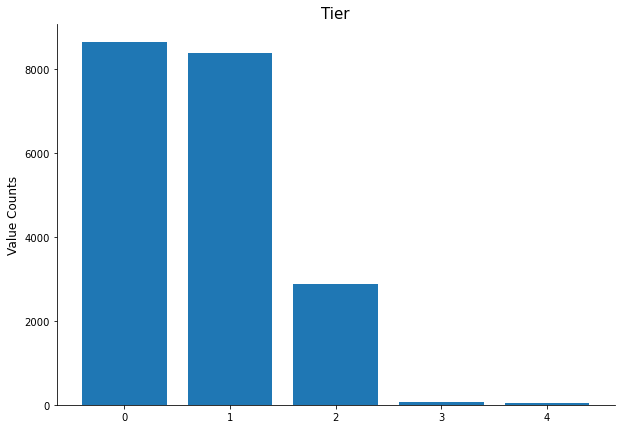

In [32]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.bar(df["tier"].unique(), df["tier"].value_counts())
ax.set_ylabel("Value Counts", fontsize = 12)
ax.set_title("Tier", fontsize = 15)
sns.despine(ax =ax)

In [33]:
stats = df.groupby("tier").agg({"id": ["count"], 
                        "average_bet": ["mean"],
                       "match_tier": ['count'],
                       "win_rate": ["mean"],
                       "best_streak": ["mean"],
                       "match_format": ["count"]})
stats

,id,average_bet,match_tier,win_rate,best_streak,match_format
,count,mean,count,mean,mean,count
tier,,,,,,
0,8366,8.281900e+06,8366,0.504528,6.567296,8366
1,8627,6.907224e+06,8627,0.512639,5.500058,8627
2,2887,5.967848e+06,2887,0.489013,4.557672,2887
3,74,6.342245e+06,74,0.568108,1.945946,74
4,46,7.331014e+06,46,0.472609,2.456522,46


In [34]:
match = df[["tier", "match_format", "average_bet", "average_bet_other"]]
match = match.groupby(["match_format", "tier"]).agg({"average_bet": "mean",
                                          "average_bet_other": "mean",
                                                    "match_format": "count"})
match

average_bet  average_bet_other  match_format
match_format tier                                               
0            0     8.181215e+06       8.660164e+06          7336
             1     6.900312e+06       6.585135e+06          7790
             2     6.082375e+06       5.836174e+06          2384
             3     6.526319e+06       8.499066e+06            70
             4     7.630736e+06       1.069601e+07            43
1            0     8.999009e+06       9.037418e+06          1030
             1     6.971560e+06       6.768266e+06           837
             2     5.425040e+06       5.460183e+06           503
             3     3.120952e+06       4.201784e+06             4
             4     3.034994e+06       2.639841e+06             3

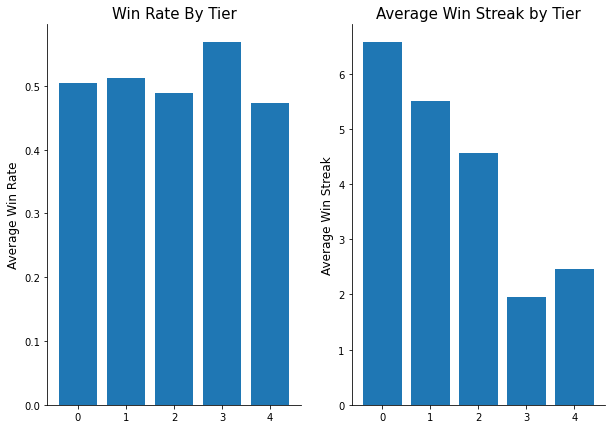

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (10, 7))
ax[0].bar(stats.index, stats["win_rate", "mean"])
ax[0].set_title("Win Rate By Tier", fontsize = 15)
ax[0].set_ylabel("Average Win Rate", fontsize = 12)

ax[1].bar(stats.index, stats["best_streak", "mean"])
ax[1].set_title("Average Win Streak by Tier", fontsize = 15)
ax[1].set_ylabel("Average Win Streak", fontsize = 12)

for i in ax:
    sns.despine(ax = i)

plt.show()

### PCA

In [36]:
## PCA with 2 components

n_comps = 2
df_pca = PCA(n_components = n_comps)
pca_fit = df_pca.fit_transform(df_scaled)

pca_explained_variance = np.var(pca_fit, axis = 0)
pca_explained_variance_ratio = pca_explained_variance / (np.sum(pca_explained_variance))

df_pcav2 = pd.DataFrame(data = pca_fit)
df_pcav2.rename(columns = {0: "PCA1",
                         1: "PCA2"}, inplace = True)

df_pcav2 = pd.concat([wins, df_pcav2], axis = 1)
df_pcav2 = df_pcav2.dropna()
print("Explained variance ratio for the 2 components with PCA:", 
      pca_explained_variance_ratio)



Explained variance ratio for the 2 components with PCA: [0.51473009 0.48526991]


### KPCA-Cosine Kernel

In [37]:
ncomps = 2
kpca = KernelPCA(n_components = ncomps, kernel = "cosine", gamma = 15)
cos_kpca = kpca.fit_transform(df_scaled)

cos_explained_variance = np.var(cos_kpca, axis = 0)
cos_explained_variance_ratio = cos_explained_variance / (np.sum(cos_explained_variance))

cos_kpca = pd.DataFrame(cos_kpca)
cos_kpca.rename(columns = {0: "cos1",
                         1: "cos2"}, inplace = True)



cos_kpca = pd.concat([wins, cos_kpca], axis = 1)
cos_kpca = cos_kpca.dropna()
print("Explained variance ratio for the 2 components with cosine kernel:", 
      cos_explained_variance_ratio)

Explained variance ratio for the 2 components with cosine kernel: [0.50481776 0.49518224]


### TSNE

In [38]:
ncomps = 2
tsne = TSNE(n_components = n_comps, random_state = 42, perplexity = 5, learning_rate = 10)
df_tsne = tsne.fit_transform(np.array(df_scaled))

tsne_explained_variance = np.var(df_tsne, axis = 0)
tsne_explained_variance_ratio = tsne_explained_variance / np.sum(tsne_explained_variance)

df_tsne = pd.DataFrame(df_tsne)
df_tsne.rename(columns = {0: "t-SNE1",
                         1: "t-SNE2"}, inplace = True)
df_tsne = pd.concat([wins, df_tsne], axis = 1)
df_tsne = df_tsne.dropna()
print("Explained variance ratio for the 2 components with t-SNE:", 
      tsne_explained_variance_ratio)

Explained variance ratio for the 2 components with t-SNE: [0.49779466 0.5022054 ]


### UMAP

In [39]:
ncomps = 2
umap = UMAP(n_components = ncomps, random_state = 42, min_dist = 0.3)
df_umap = umap.fit_transform(np.array(df_scaled))

umap_explained_variance = np.var(df_umap, axis = 0)
umap_explained_variance_ratio = umap_explained_variance / np.sum(umap_explained_variance)

df_umap = pd.DataFrame(df_umap)
df_umap.rename(columns = {0: "umap1",
                         1: "umap2"}, inplace = True)
df_umap = pd.concat([wins, df_umap], axis = 1)
df_umap = df_umap.dropna()

print("Explained variance ratio for the 2 components with U-Map:", 
      umap_explained_variance_ratio)

Explained variance ratio for the 2 components with U-Map: [0.3525567  0.64744335]


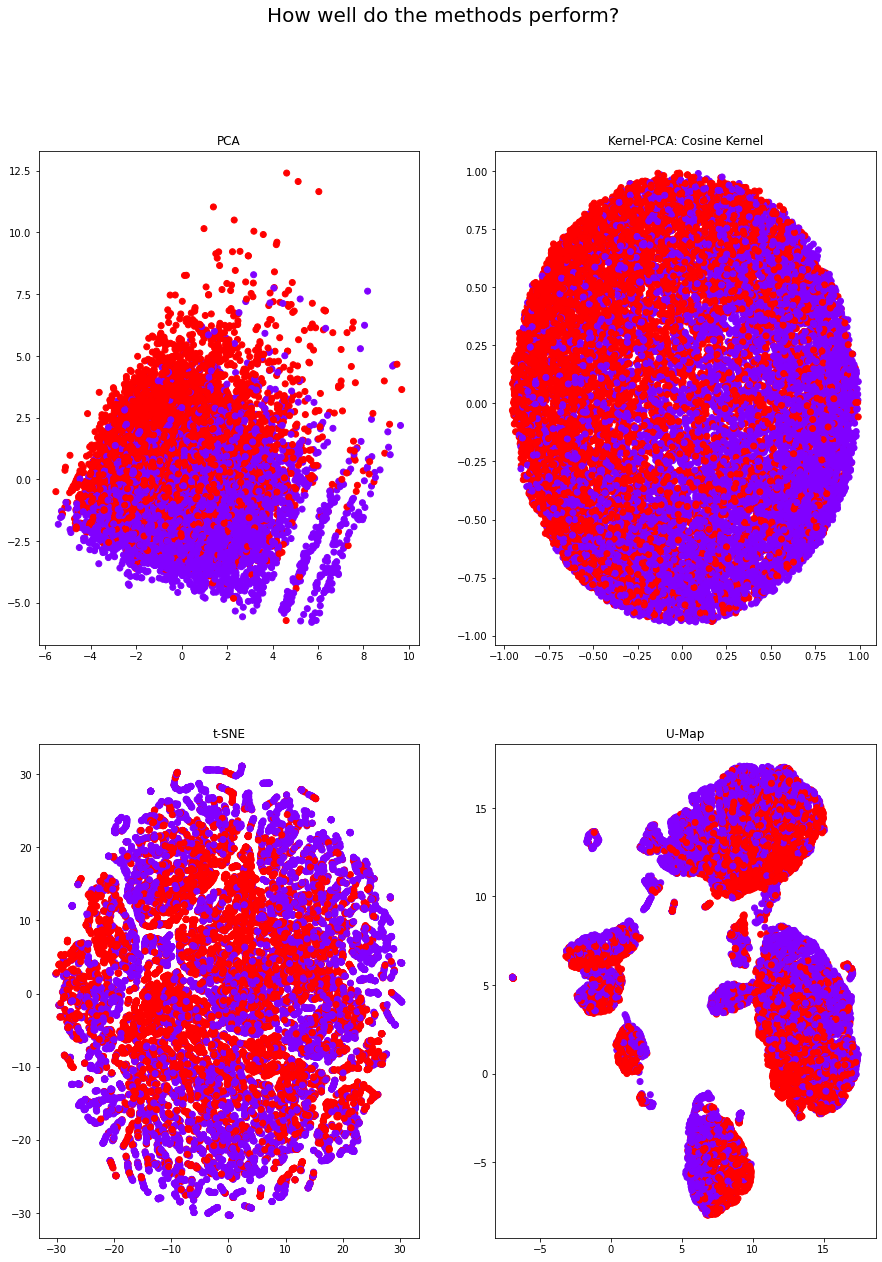

In [40]:
fig, ax = plt.subplots(2, 2, figsize = (15, 20))
ax[0][0].set_title("PCA")

ax[0][0].scatter(df_pcav2["PCA1"], df_pcav2["PCA2"],
            c = df_pcav2["winner_binary"], cmap = "rainbow")

ax[0][1].set_title("Kernel-PCA: Cosine Kernel")
ax[0][1].scatter(cos_kpca["cos1"], cos_kpca["cos2"],
            c = cos_kpca["winner_binary"], cmap = "rainbow")


ax[1][0].set_title("t-SNE")
ax[1][0].scatter(df_tsne["t-SNE1"], df_tsne["t-SNE2"],
            c = df_tsne["winner_binary"], cmap = "rainbow")


ax[1][1].set_title("U-Map")
ax[1][1].scatter(df_umap["umap1"], df_umap["umap2"],
            c = df_umap["winner_binary"], cmap = "rainbow")


plt.suptitle("How well do the methods perform?", fontsize = 20)
plt.show()

- Based on the plots above, we can see u-map does the best in separating fighters, although there are alot of overlap, indicating that winning and losing isn't the only thing that differentiates fighters